In [187]:
from qiskit import __version__
from qiskit_aer import __version__

print("Qiskit version: ", __version__)
print("Qiskit Aer version: ", __version__)

Qiskit version:  0.14.1
Qiskit Aer version:  0.14.1


## Encoding and Preparation

We start by initializing our circuit. We will need a total of 3 qubits and 3 classical bits. The `QuantumRegister` and `ClassicalRegister` objects are just conveniences to help us keep track of which qubit (or classical bit) is which. If you don't like, you could instantiate the quantum circuit directly with `QuantumCircuit(3, 3)`.

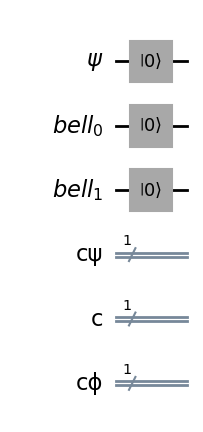

In [188]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Register qubits and classical bits
ψ = QuantumRegister(1, 'ψ')
cψ = ClassicalRegister(1, 'cψ')

bell = QuantumRegister(2, 'bell')
c = ClassicalRegister(1, 'c')
cϕ = ClassicalRegister(1, 'cϕ') #This will be used to read the final result

# Create a quantum circuit
qc = QuantumCircuit(ψ, bell, cψ, c, cϕ)
qc.reset(ψ)
qc.reset(bell)

qc.draw(output='mpl') #Needs pylatexenc, you can also just call .draw() to get a text representation

Now, we will prepare the qubit we want to send. This is done with a series of operations that end up with the configuration that you want. 

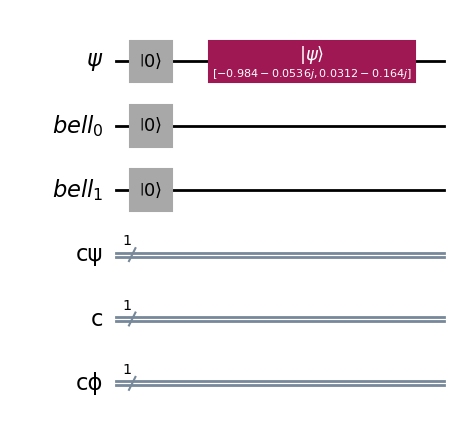

In [189]:
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize

#Generate two random complex numbers
random_vec = random_statevector(2)

#We will store the squared probabilities for future reference
probs = np.abs(random_vec)**2
probs = {0: probs[0], 1: probs[1]}

state = Initialize(random_vec)
qc.append(state, ψ)

qc.draw(output='mpl')

In [190]:
#Peeking at the expected probabilities

probs

{0: 0.972049603070859, 1: 0.027950396929141353}

The next step is to prepare out Bell state. This will output an entangled state of two qubits. The standard way to do this is to apply a Hadamard gate to the first qubit and then a CNOT gate with the first qubit as the control and the second qubit as the target.

The process works like this:

1. Start with zeroes. This is just a choice and you could start with any other state.

$$|0\rangle \otimes |0\rangle$$

2. Apply the Hadamard gate to the first qubit.

$$H \otimes I(|0\rangle \otimes |0\rangle) = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)\otimes|0\rangle$$

3. Apply CNOT gate.

$$I \otimes CNOT \left(\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)\otimes|0\rangle\right) = \frac{1}{\sqrt{2}}\left(|0\rangle \otimes |0\rangle + |1\rangle\otimes|1\rangle \right)$$

So at the output of the bell qubits, we expect it to be either $|00\rangle$ or $|11\rangle$ with equal probability.

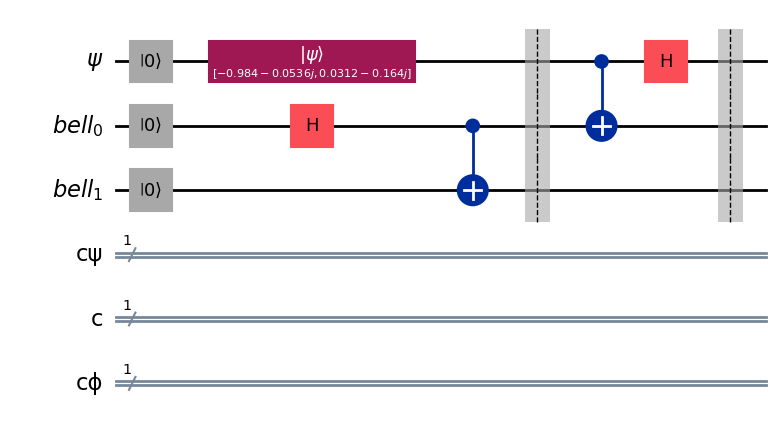

In [191]:
qc.h(bell[0])
qc.cx(bell[0], bell[1])

qc.barrier() #This is just for visualization purposes

qc.draw(output='mpl')

Now, we will entangle the qubit we want to send with the first qubit of the Bell state. This is done by applying a CNOT gate with the qubit we want to send as the control and the first qubit of the Bell state as the target and then applying a Hadamard gate to the qubit we want to send.

Mathematically this becomes:

1. State after Bell entanglement:

$$\frac{1}{\sqrt{2}}(\alpha|1\rangle +\beta |0\rangle)\otimes\left(|0\rangle \otimes |0\rangle + |1\rangle\otimes|1\rangle \right)$$

or

$$\frac{\alpha}{\sqrt{2}}|000\rangle + \frac{\alpha}{\sqrt{2}}|011\rangle + \frac{\beta}{\sqrt{2}}|100\rangle + \frac{\beta}{\sqrt{2}}|111\rangle$$

2. Apply CNOT gate.

$$\frac{\alpha}{\sqrt{2}}|000\rangle + \frac{\alpha}{\sqrt{2}}|011\rangle + \frac{\beta}{\sqrt{2}}|110\rangle + \frac{\beta}{\sqrt{2}}|101\rangle$$

or 

$$\frac{\alpha}{\sqrt{2}}|0\rangle \otimes \left(|0\rangle \otimes |0\rangle + |1\rangle\otimes|1\rangle \right) + \frac{\beta}{\sqrt{2}}|1\rangle \otimes \left(|1\rangle \otimes |0\rangle + |0\rangle\otimes|1\rangle \right)$$

3. Apply Hadamard gate and simplify

$$\frac{1}{2}\left[|00\rangle \otimes \left(\alpha |0\rangle + \beta |1\rangle\right) + |01\rangle \otimes \left(\alpha |1\rangle + \beta |0\rangle\right) + |10\rangle \otimes \left(\alpha |0\rangle - \beta |1\rangle\right) + |11\rangle \otimes \left(\alpha |1\rangle - \beta |0\rangle\right)\right]$$

Notice how what ends up in the parentheses has the same amplitude we want to send with some phase. The first term is exactly what we want to send, the second one has the bits 0 and 1 flipped (solvable by an X gate), the third one needs to change the sign of 1 (using a Z gate), and the latter has both the bits flipped and the sign changed (solvable by a ZX gate).

In [ ]:
qc.cx(ψ, bell[0])
qc.h(ψ)

qc.barrier()

Finally, we read the outcome of out prepared qubit and the first entangled qubit to send it to the receiver.

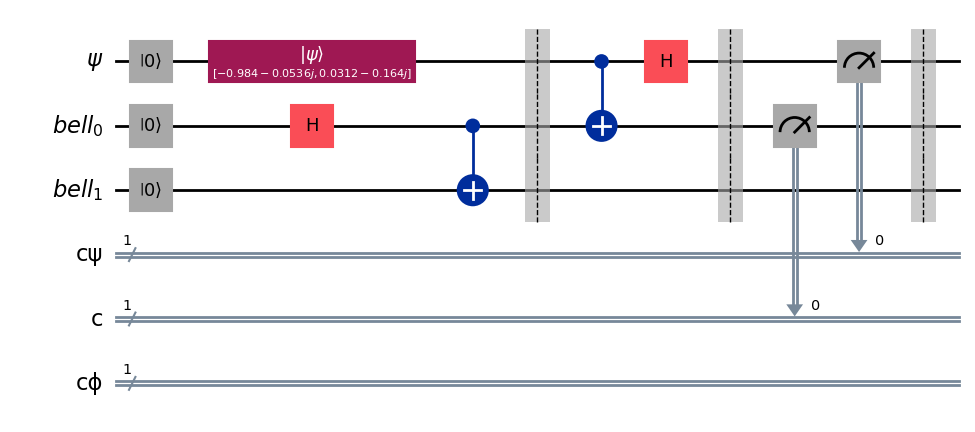

In [192]:
qc.measure(bell[0], c)
qc.measure(ψ, cψ)
qc.barrier()

qc.draw(output='mpl')

## Decoding

Once the receiver got the measurements made earlier along with the second entangled state (`bell_1`). We can move on to the deconding process. The procedure is as follows:

| Received | Gate Applied |
|----------|--------------|
| 00       | I           |
| 01       | X           |
| 10       | Z           |
| 11       | ZX          |

Notice that the order of the operations is inverted when we actually apply the gates. So, the `ZX` gate actually means to apply the `X` gate followed by the `Z` gate.

Luckly, we can encode this whole process with the `.c_if` method of Qiskit. You can think of it as the same as a controlled gate, except that the control is a classical bit. So, if the classical bit is 1, the gate is applied, otherwise it is not.

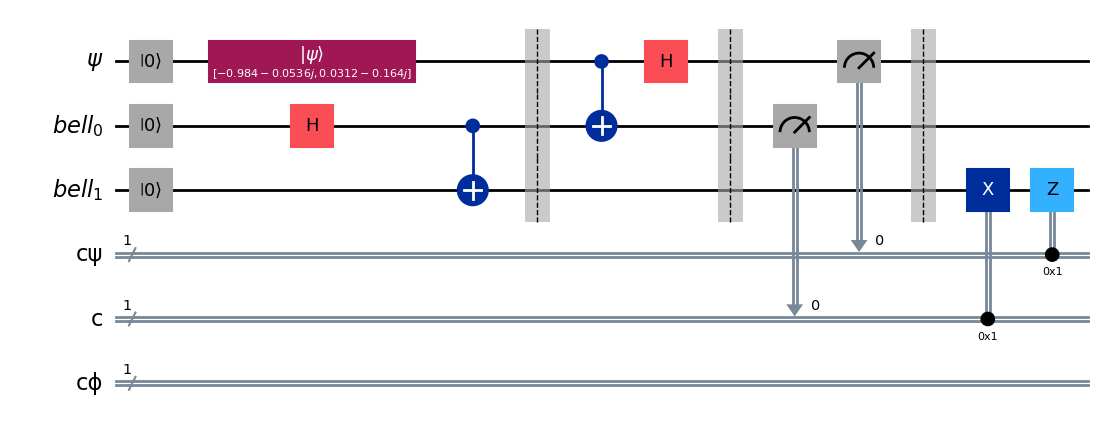

In [193]:
qc.x(bell[1]).c_if(c, 1)
qc.z(bell[1]).c_if(cψ, 1)

qc.draw(output='mpl')

# Reading out the Outcome with Ensemble Statistics

One way to find out whether our protocol is working is via an ensemble method. The idea revolves in running this code many times over and then checking the statistics of the outcomes. If the protocol is working, we should see that the outcomes are $|0\rangle$ and $|1\rangle$ with the same probability that we started with (the `probs`) variable.

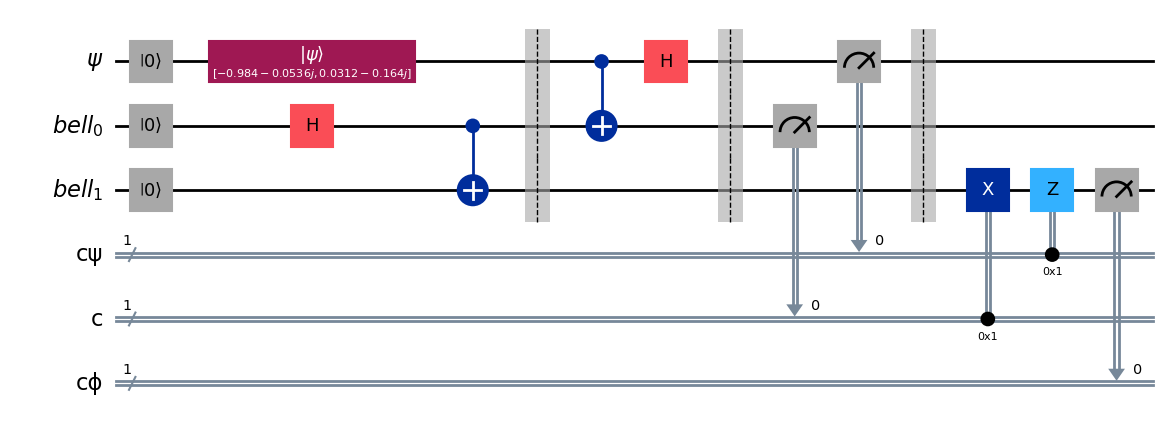

In [194]:
#Measure the final state
qc.measure(bell[1], cϕ)

qc.draw(output='mpl')

In [195]:
from qiskit_aer import AerSimulator

simulator = AerSimulator()
result = simulator.run(qc, shots=10000).result()

print(result.get_counts())

{'1 1 0': 65, '1 0 1': 69, '1 0 0': 73, '0 0 1': 2341, '0 0 0': 2453, '0 1 0': 2465, '1 1 1': 55, '0 1 1': 2479}


In oder to make things humanly readable, we will focus only on the third bit, which is the one we are actually reading in the receiveing end. The other two bits are due to the intermediate measurements we made to prepare the qubit.

In [196]:
probs

{0: 0.972049603070859, 1: 0.027950396929141353}

In [197]:
from collections import Counter

receiver_counts = Counter()
receiver_counts = Counter()
for k, v in result.get_counts().items():
    receiver_counts[k[0]] += v/1000 #The order is inverted, so the first bit is the last one

Now, we should see the distributions of the outcomes to be fairly close to the `probs` variable. You can run this code multiple times to see how the distributions change.

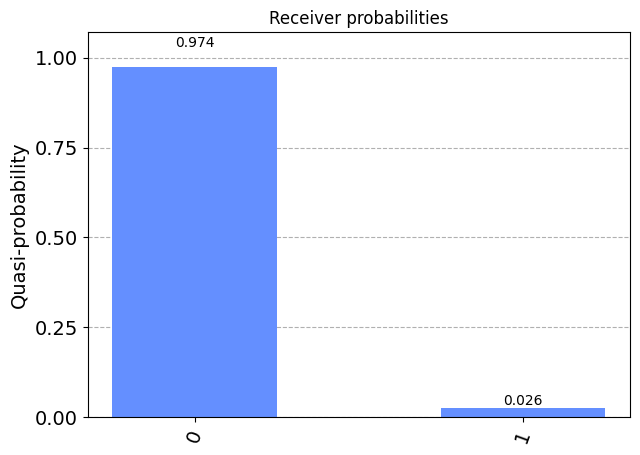

In [198]:
from qiskit.visualization import plot_histogram

plot_histogram(receiver_counts, title='Receiver probabilities')

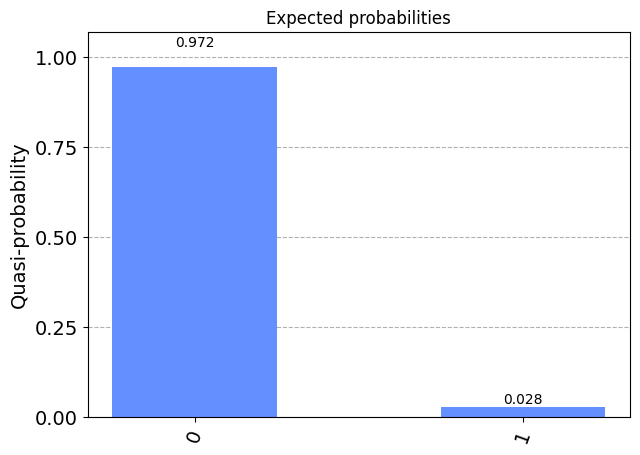

In [199]:
plot_histogram(probs, title='Expected probabilities')